# Классификация табличных данных на основе нейросетевых моделей
### 7 Вариант
Дан набор данных включает данные для оценки уровней ожирения у людей из
Мексики, Перу и Колумбии на основе их привычек питания и физического
состояния. Данные содержат 17 атрибутов и 2111 записей, записи помечены
классовой переменной NObeyesdad (Уровень ожирения), что позволяет
классифицировать данные, используя значения Insufficient Weight, Normal
Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and
Obesity Type III. Построить классификационную модель для целевого признака
«NObeyesdad» от остальных входных признаков, определяющего физическое
состояние человека.
a. Пункт 5 – двунаправленная GRU рекуррентная сеть
b. Пункт 3.h – Min-max масштабирование

## Загрузка набора данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_data(filename:str):
    return pd.read_csv(filename+".csv")
dataset = load_data("V7")

## Анализ атрибутов набора данных

Изучим список параметров в наборе данных

In [2]:
dataset.head()

Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

- Gender: Пол человека (Male или Female).
- Age: Возраст человека в годах.
- Height: Рост человека в метрах.
- Weight: Вес человека в килограммах.
- family_history_with_overweight: Наличие семейной предрасположенности к избыточному весу (yes или no).
- FAVC (Frequent Availability of Caloric Food): Частое употребление калорийной пищи (yes или no).
- FCVC (Frequency of Consumption of Vegetables): Частота употребления овощей.
- NCP (Number of Main Meals per Day): Количество основных приемов пищи в день.
- CAEC (Consumption of Food between Meals): Частота употребления пищи между основными приемами
- SMOKE: Курение (yes или no).
- CH2O (Daily Water Consumption): Среднее количество потребляемой воды в литрах за день.
- SCC (Calories Consumption Monitoring): Контроль потребления калорий (yes или no).
- FAF (Physical Activity Frequency): Частота физической активности.
- TUE (Time Using Technology Devices): Среднее время использования электронных устройств (компьютеров, телефонов) в часах в день.
- CALC (Alcohol Consumption): Частота потребления алкоголя (no, Sometimes, Frequently, Always).
- MTRANS (Transportation Mode): Основной вид транспорта, используемый для передвижения
- NObeyesdad: Уровень ожирения.

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

В наборе данных нет параметров с пропущенным значением, поэтому очищать данные не будем. Видно, что имеется много категориальных признаков, которые необходимо будет преобразовать в более машино читабельный вид.

Целевой атрибут - **NObeyesdad(Степень ожирения)**. Рассмотрим значения, которые встречаются у него.

In [4]:
dataset['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

Значения распределены довольно равномерно, более показательно это можно будет увидеть на гистограмме распределения далее.

### Гистограммы для числовых признаков

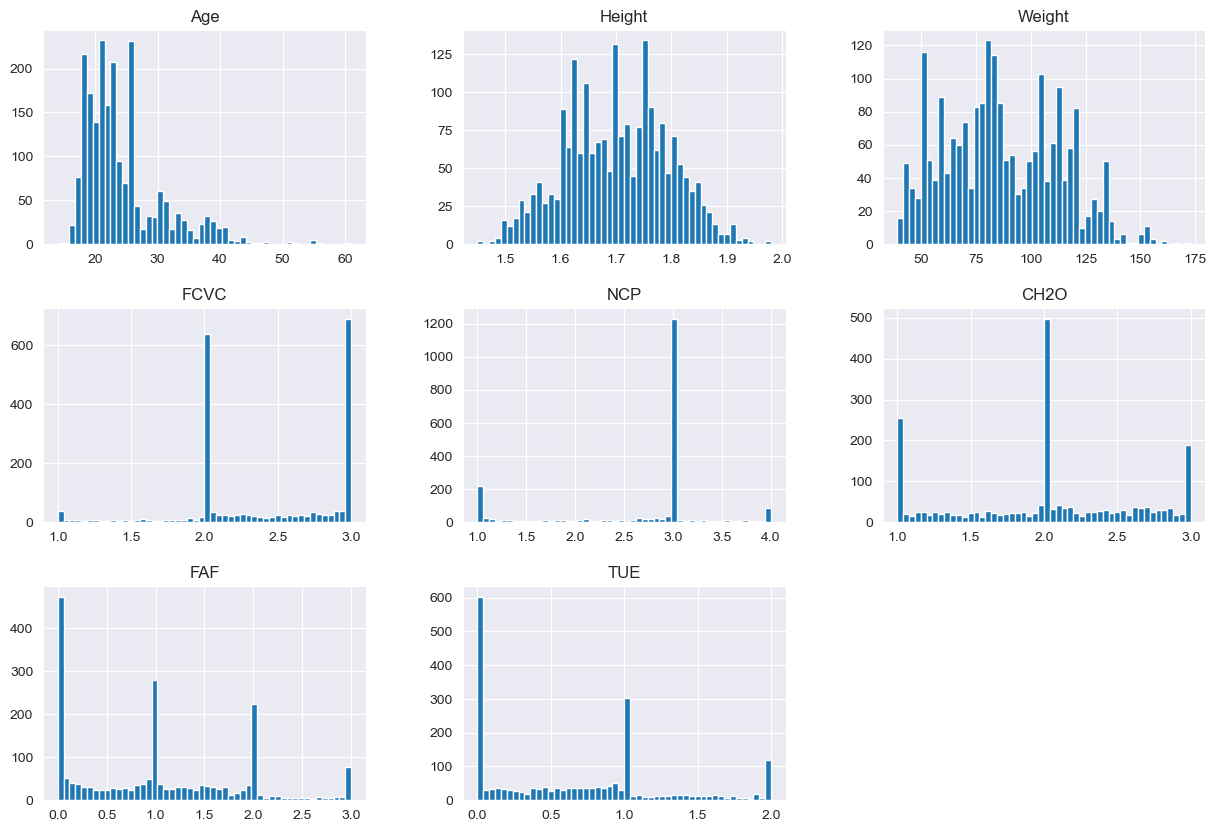

In [5]:
dataset.hist(bins=50,figsize=(15, 10))
plt.show()

#### Комментарии к гистограммам распределения

Основная часть значений Age сосредоточена в диапазоне 10-30 лет, после чего частота значительно падает. Видно, что приблизительно к 20 годам получаем пик количества значений, после которого график постепенно падает. 40+ значения довольно дискретные. 

Распределения Height и Weight приближены к нормальному. У веса основная часть значений распределена в диапазоне от 50 до 120, что дает большую выборку разных значений. 

FCVC имеет дискретные значения с выраженными пиками, что говорит о некоторой категориальности признака, большинство значений это 2 или 3.

Распределение NCP дискретное, с ярко выраженными пиком у 3, что отражает обычное количество приемов пищи у человека. Также можно выделить пики в значениях 1 и 4.

Переменная CH2O также имеет дискретное распределение с пиками на конкретных значениях 1,2,3 литра.

Распределение FAF дискретное, с ярко выраженными пиками на значениях 0,1,2,3. 

У TUE также дискретное распределение с пиками на значениях 0,1,2. 

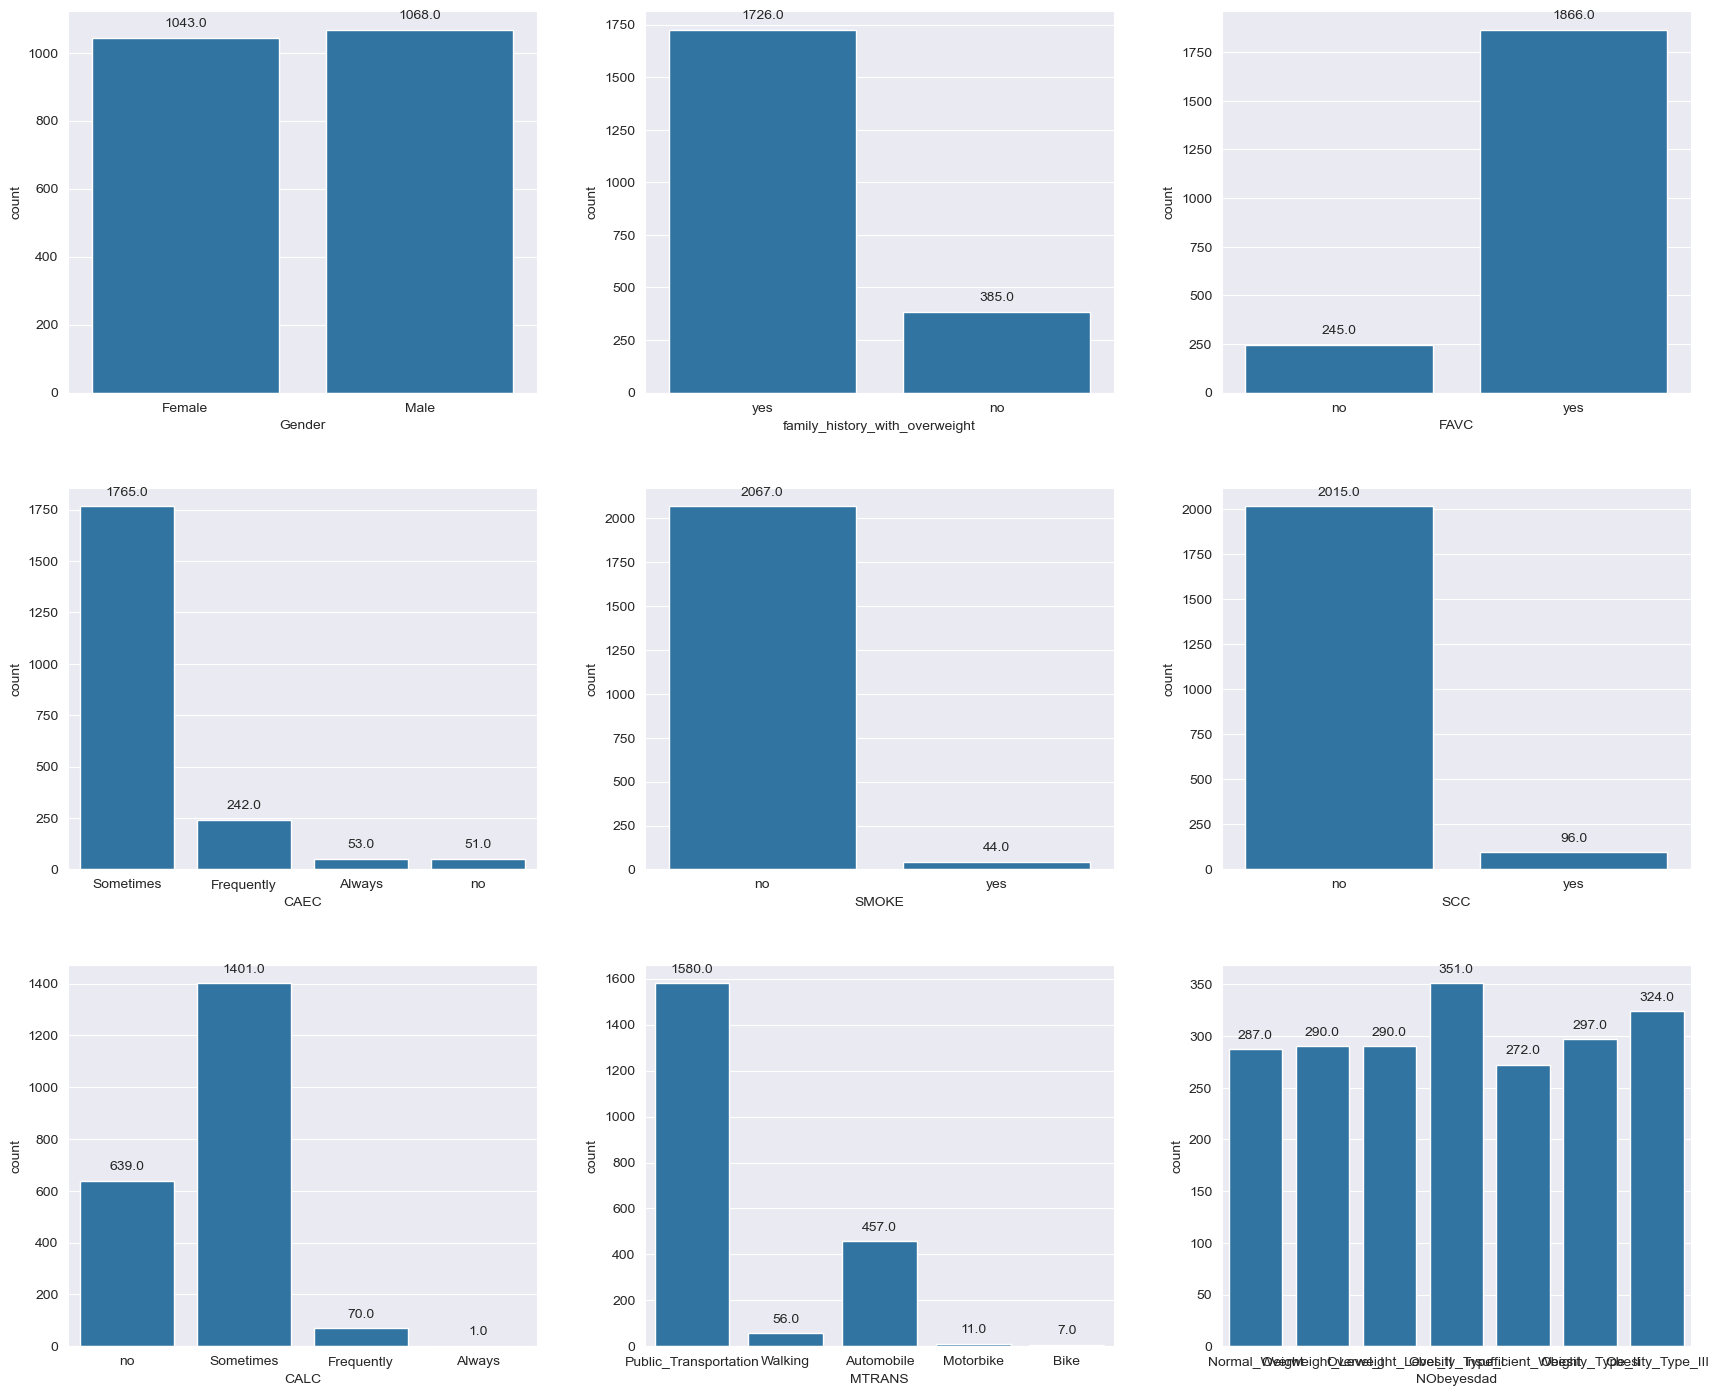

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.tight_layout(pad=5.0) 

for i, feature in enumerate(categorical_features):
    row, col = divmod(i, 3) 
    ax = sns.countplot(data=dataset, x=feature, ax=axes[row, col]) 

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

#### Анализ гистограмм распределения категориальных признаков

NObeyesdad, Gender распределены почти равномерно.  

Из гистограммы SMOKE видно, почти все участники опроса не курят. Скорее всего этот показатель будет иметь маленькое влияние на итоговый результат. Похожая ситуация с SCC, но не такая ярко выраженная. 

У остальных признаков в большинстве своём имеются пики в определенном значении, а остальные значения сильно реже встречаются. Например, у CAEC преобладает значение **Sometimes**. 

#### Вывод
Получается, что в наборе данных 9 из 17 атрибутов - категориальные и имеют конкретные дискретные значения. При этом если рассматривать числовые атрибуты, то выходит, что 5 атрибутов имеют хоть и разнообразные значения, но с ярко выраженными пиками в определенных значениях. Это приближает их также к дискретным категориальным атрибутам. И только Возраст, Вес и Рост имеют некоторое разнообразное распределение (приближенное к нормальному в случае с Ростом и весом). 

### Анализ соотношений атрибутов друг к другу

#### Попарная матрица рассеяния
Данная матрица построена для каждой пары атрибутов с обозначением влияния этих атрибутов на искомый результат - атрибут NObeyesdad

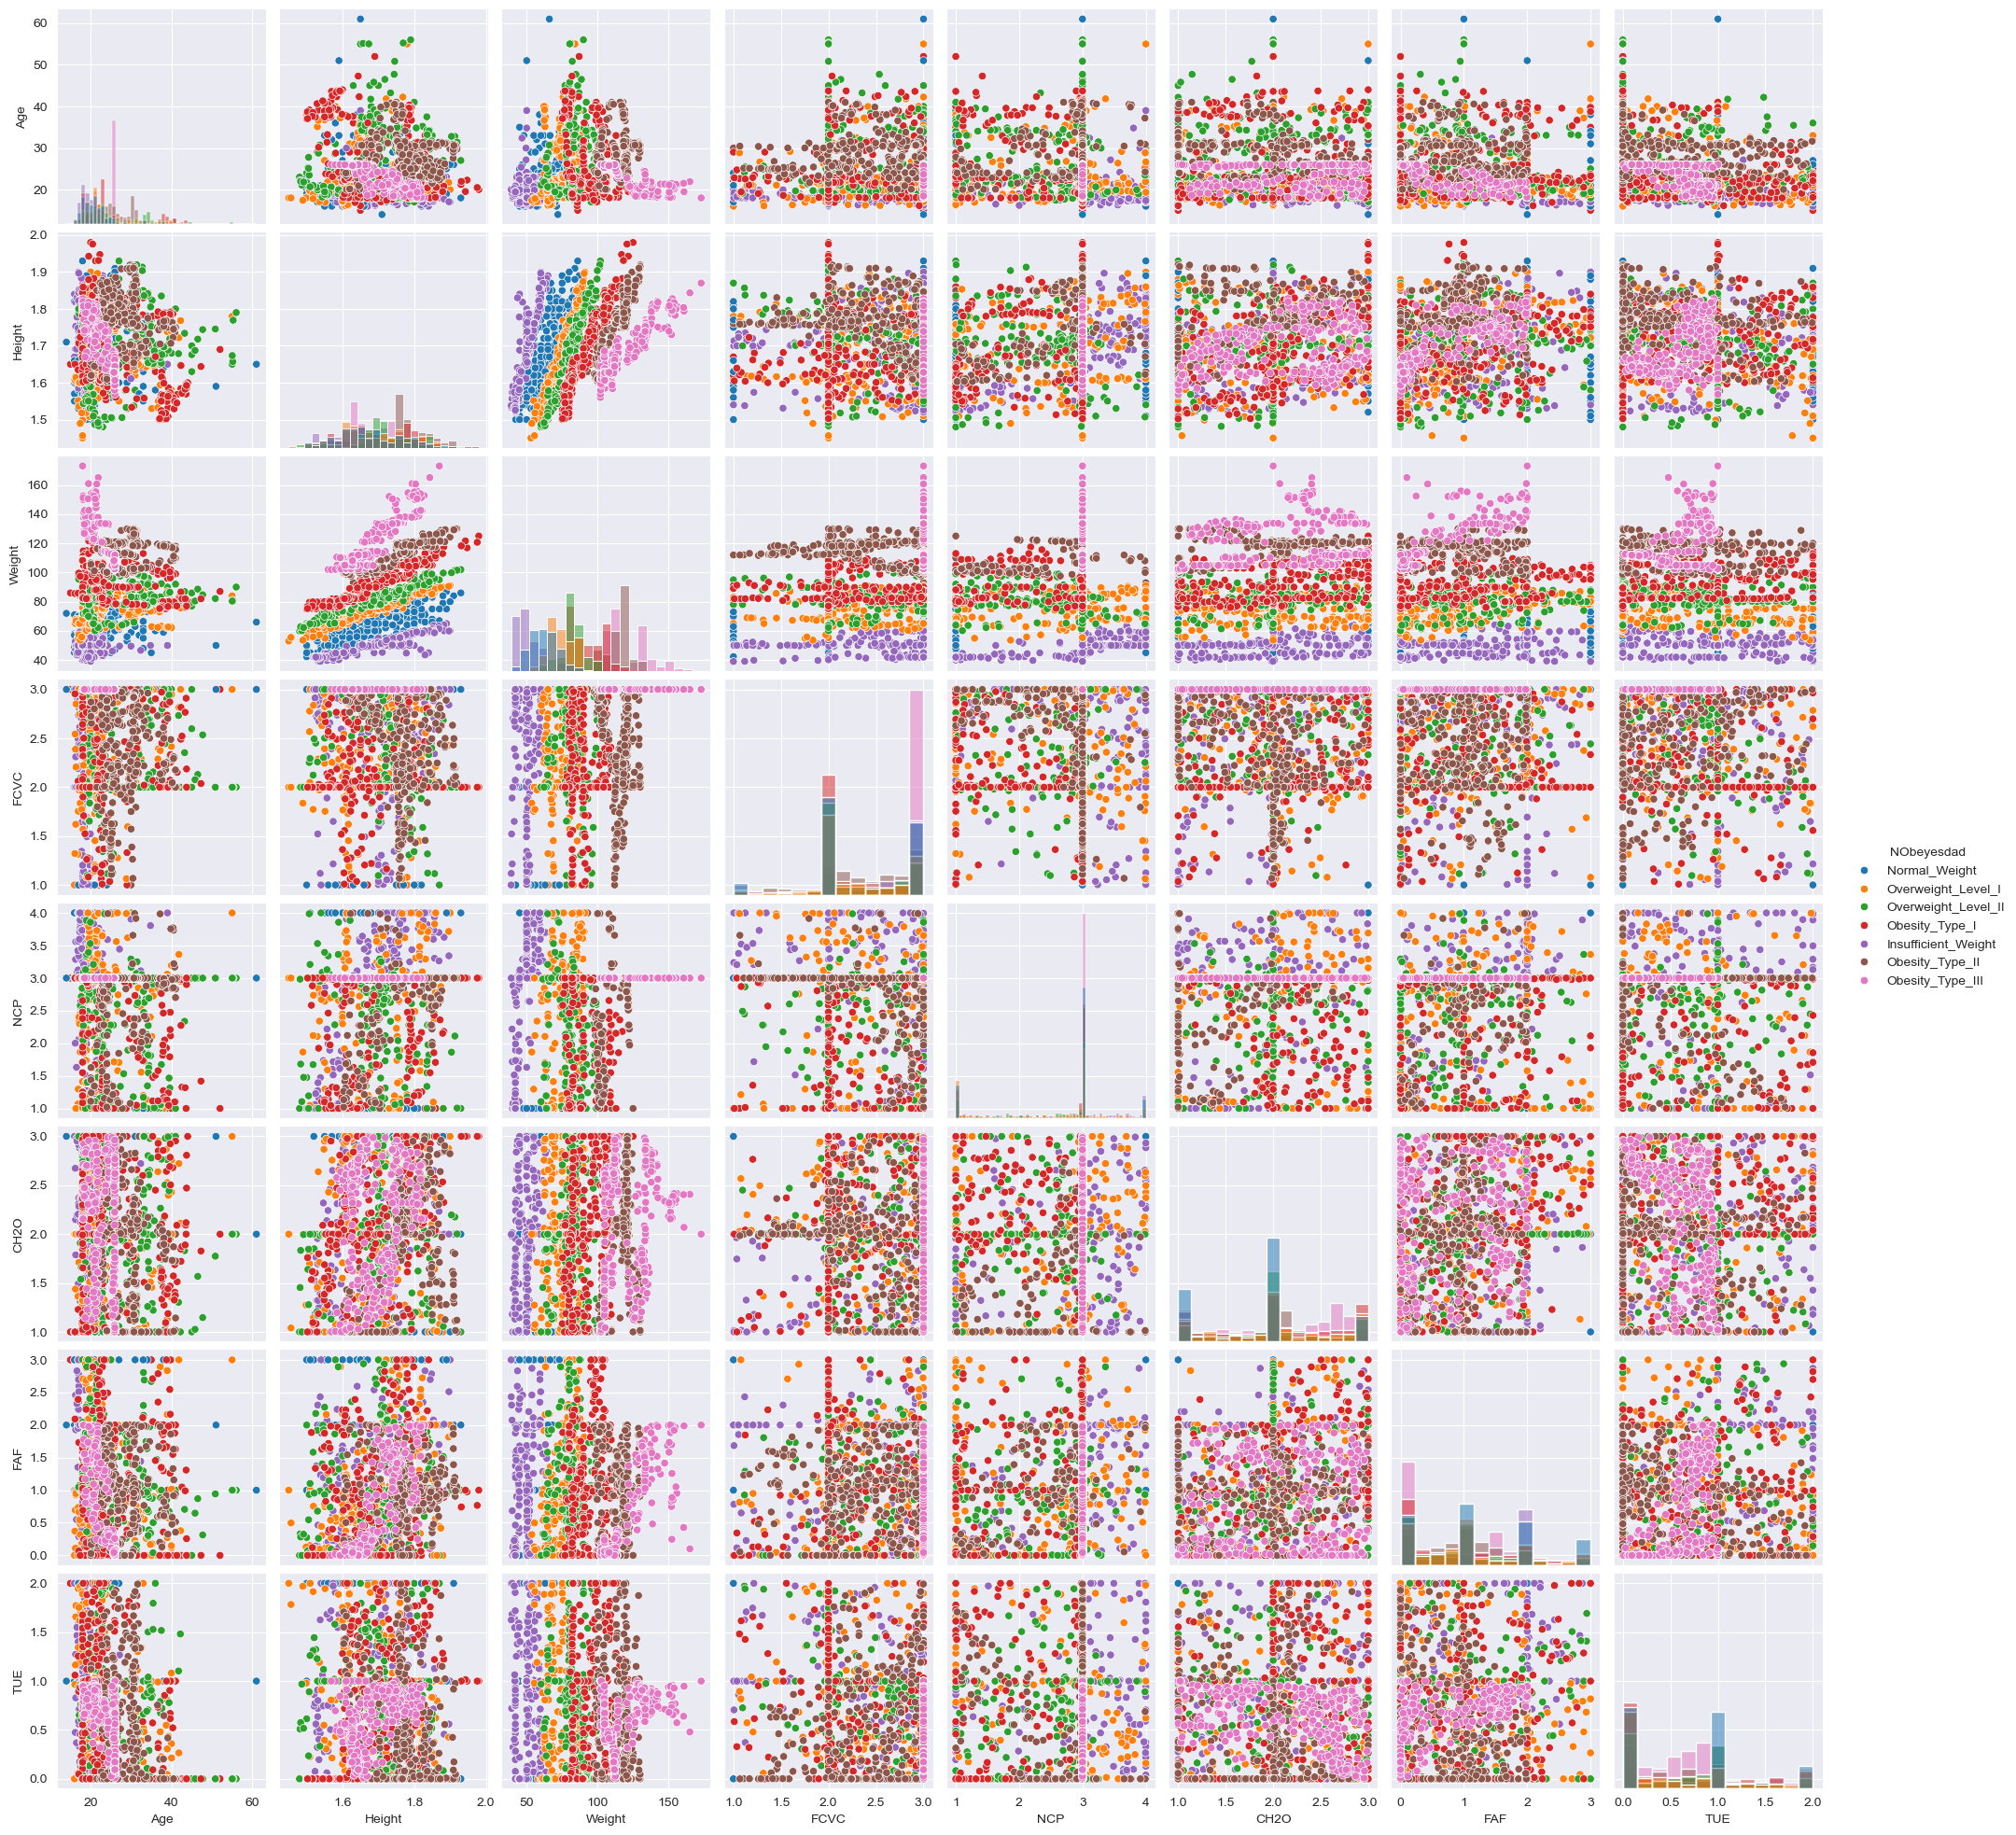

In [7]:
sns.pairplot(dataset, hue="NObeyesdad", diag_kind="hist")
plt.show()

Сразу заметно четкое разделение уровней ожирения в соотношениях веса и роста, что логично, так как степень ожирения напрямую зависит от индекса массы тела, который представляет собой формулу: 
`ИМТ = Масса/Рост^2` 

Также заметно менее явное распределение на всех пересечениях веса с другими параметрами, кроме возраста. 
Остальные соотношения довольно хаотичные, где вряд ли есть закономерность.  

### Преобразование категориальных параметров

In [8]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
dataset['Gender'] = encoder.fit_transform(dataset[['Gender']])
dataset['family_history_with_overweight'] = encoder.fit_transform(dataset[['family_history_with_overweight']])
dataset['FAVC'] = encoder.fit_transform(dataset[['FAVC']])
dataset['SMOKE'] = encoder.fit_transform(dataset[['SMOKE']])
dataset['SCC'] = encoder.fit_transform(dataset[['SCC']])
dataset['CAEC'] = encoder.fit_transform(dataset[['CAEC']])
dataset['CALC'] = encoder.fit_transform(dataset[['CALC']])
dataset['MTRANS'] = encoder.fit_transform(dataset[['MTRANS']])
dataset['NObeyesdad'] = encoder.fit_transform(dataset[['NObeyesdad']])

Преобразовали категориальные параметры в числовые значения с помощью `OrdinalEncoder`. Посмотрим, как теперь выглядит dataset.

In [22]:
dataset.head(10)

Gender   Age  Height  Weight  family_history_with_overweight  FAVC  FCVC  \
0     0.0  21.0    1.62    64.0                             1.0   0.0   2.0   
1     0.0  21.0    1.52    56.0                             1.0   0.0   3.0   
2     1.0  23.0    1.80    77.0                             1.0   0.0   2.0   
3     1.0  27.0    1.80    87.0                             0.0   0.0   3.0   
4     1.0  22.0    1.78    89.8                             0.0   0.0   2.0   
5     1.0  29.0    1.62    53.0                             0.0   1.0   2.0   
6     0.0  23.0    1.50    55.0                             1.0   1.0   3.0   
7     1.0  22.0    1.64    53.0                             0.0   0.0   2.0   
8     1.0  24.0    1.78    64.0                             1.0   1.0   3.0   
9     1.0  22.0    1.72    68.0                             1.0   1.0   2.0   

   NCP  CAEC  SMOKE  CH2O  SCC  FAF  TUE  CALC  MTRANS  NObeyesdad  
0  3.0   2.0    0.0   2.0  0.0  0.0  1.0   3.0     3.0         1.0  
1  3.0   2.0    1.0   3.0  1.0  3.0  0.0   2.0     3.0         1.0  
2  3.0   2.0    0.0   2.0  0.0  2.0  1.0   1.0     3.0         1.0  
3  3.0   2.0    0.0   2.0  0.0  2.0  0.0   1.0     4.0         5.0  
4  1.0   2.0    0.0   2.0  0.0  0.0  0.0   2.0     3.0         6.0  
5  3.0   2.0    0.0   2.0  0.0  0.0  0.0   2.0     0.0         1.0  
6  3.0   2.0    0.0   2.0  0.0  1.0  0.0   2.0     2.0         1.0  
7  3.0   2.0    0.0   2.0  0.0  3.0  0.0   2.0     3.0         1.0  
8  3.0   2.0    0.0   2.0  0.0  1.0  1.0   1.0     3.0         1.0  
9  3.0   2.0    0.0   2.0  0.0  1.0  1.0   3.0     3.0         1.0

### Анализ матрицы корреляций и попарной матрицы рассеяния после преобразования категориальных признаков

Получим матрицу корреляций

In [10]:
corr_matrix  = dataset.corr()
corr_matrix

Gender       Age    Height    Weight  \
Gender                          1.000000  0.048394  0.618466  0.161668   
Age                             0.048394  1.000000 -0.025958  0.202560   
Height                          0.618466 -0.025958  1.000000  0.463136   
Weight                          0.161668  0.202560  0.463136  1.000000   
family_history_with_overweight  0.102512  0.205725  0.247684  0.496820   
FAVC                            0.064934  0.063902  0.178364  0.272300   
FCVC                           -0.274505  0.016291 -0.038121  0.216125   
NCP                             0.067600 -0.043944  0.243672  0.107469   
CAEC                            0.091543  0.083739  0.048818  0.287493   
SMOKE                           0.044698  0.091987  0.055499  0.025746   
CH2O                            0.107930 -0.045304  0.213376  0.200575   
SCC                            -0.102633 -0.116283 -0.133753 -0.201906   
FAF                             0.189607 -0.144938  0.294709 -0.051436   
TUE                             0.017269 -0.296931  0.051912 -0.071561   
CALC                            0.007616 -0.044487 -0.129732 -0.206677   
MTRANS                         -0.137537 -0.601945 -0.073609  0.004610   
NObeyesdad                      0.024908  0.236170  0.038986  0.387643   

                                family_history_with_overweight      FAVC  \
Gender                                                0.102512  0.064934   
Age                                                   0.205725  0.063902   
Height                                                0.247684  0.178364   
Weight                                                0.496820  0.272300   
family_history_with_overweight                        1.000000  0.208036   
FAVC                                                  0.208036  1.000000   
FCVC                                                  0.040372 -0.027283   
NCP                                                   0.071370 -0.007000   
CAEC                                                  0.169787  0.150068   
SMOKE                                                 0.017385 -0.050660   
CH2O                                                  0.147437  0.009719   
SCC                                                  -0.185422 -0.190658   
FAF                                                  -0.056673 -0.107995   
TUE                                                   0.022943  0.068417   
CALC                                                  0.036676 -0.089520   
MTRANS                                               -0.101540 -0.069800   
NObeyesdad                                            0.313667  0.044582   

                                    FCVC       NCP      CAEC     SMOKE  \
Gender                         -0.274505  0.067600  0.091543  0.044698   
Age                             0.016291 -0.043944  0.083739  0.091987   
Height                         -0.038121  0.243672  0.048818  0.055499   
Weight                          0.216125  0.107469  0.287493  0.025746   
family_history_with_overweight  0.040372  0.071370  0.169787  0.017385   
FAVC                           -0.027283 -0.007000  0.150068 -0.050660   
FCVC                            1.000000  0.042216 -0.054670  0.014320   
NCP                             0.042216  1.000000 -0.097801  0.007811   
CAEC                           -0.054670 -0.097801  1.000000 -0.055282   
SMOKE                           0.014320  0.007811 -0.055282  1.000000   
CH2O                            0.068461  0.057088  0.144995 -0.031995   
SCC                             0.071852 -0.015624 -0.109179  0.047731   
FAF                             0.019939  0.129504 -0.030110  0.011216   
TUE                            -0.101135  0.036326 -0.048567  0.017613   
CALC                           -0.060781 -0.071747 -0.047540 -0.082471   
MTRANS                          0.064743 -0.053858 -0.048535 -0.010702   
NObeyesdad                      0.018522 -0.092616  0.327295 -0.023256   


Рассмотрим корреляцию признаков к целевому признаку **NObeyesdad** с сортировкой по модулю.

In [23]:
y_column_name = "NObeyesdad"
corr_matrix[y_column_name].sort_values(ascending = False, key=abs)

NObeyesdad                        1.000000
Weight                            0.387643
CAEC                              0.327295
family_history_with_overweight    0.313667
Age                               0.236170
CALC                             -0.134632
FAF                              -0.129564
CH2O                              0.108868
NCP                              -0.092616
TUE                              -0.069448
SCC                              -0.050679
MTRANS                           -0.046202
FAVC                              0.044582
Height                            0.038986
Gender                            0.024908
SMOKE                            -0.023256
FCVC                              0.018522
Name: NObeyesdad, dtype: float64

Заметна хорошая корреляция у Weight, CAEC, family_history_with_overweight, Age. 

Построим попарные графики для преобразованного набора данных, теперь числовых атрибутов стало 17, для каждого пересечения построим график рассеяния. 

**Так как график строится долго, то код закомментирован и итоговый результат вставлен в виде картинки** 

In [12]:
# Попарные графики
#sns.pairplot(dataset, hue="NObeyesdad", diag_kind="hist")
#plt.show()

![image](output.png)

В большинстве параметров рассеяние довольно хаотичное. Можно примерно выделить некоторые соотношения и далее проверить их значимость для итогового результата.

Например, соотношение CAEC и TUE, CH2O и MTRANS, family_history_with_overweight и FCVC, CALC и FCVC, SCC и CH2O.

### Отбор существенных(информативных) признаков 

#### Информативность признаков до добавлений новых

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif

def calc_best_features(ds):
    X = ds.drop(y_column_name, axis=1)
    y = ds[y_column_name]
    selector = SelectKBest(score_func=f_classif, k=10)
    
    fit = selector.fit(X,y)
    dfscores = pd.DataFrame({"fit":fit.scores_})
    dfcolumns = pd.DataFrame({"title":X.columns})
    fscores = pd.concat([dfcolumns,dfscores],axis=1)
    return fscores.sort_values(ascending = False,by = "fit")

calc_best_features(dataset)

title          fit
3                           Weight  1966.518018
0                           Gender   158.712595
4   family_history_with_overweight   146.477128
6                             FCVC   112.315462
8                             CAEC    81.096953
1                              Age    77.954154
5                             FAVC    43.578216
2                           Height    38.432313
14                            CALC    33.954742
15                          MTRANS    27.372766
7                              NCP    26.811662
11                             SCC    21.700653
12                             FAF    17.484200
10                            CH2O    16.171142
13                             TUE     7.876656
9                            SMOKE     5.421074

#### Добавление новых признаков

Добавим новые признаки из соотношений исходных признаков. Добавляем ИМС, все соотношения числовых атрибутов к весу, и вышеупомянутые соотношения.

In [25]:
dataset_clean = dataset.copy(deep=True)

# Индекс массы тела
dataset_clean['BMI'] = dataset_clean['Weight'] / (dataset_clean['Height'] ** 2)
dataset_clean['W2FCVC'] = dataset_clean['Weight'] / (dataset_clean['FCVC'])
dataset_clean['W2Age'] = dataset_clean['Weight'] / (dataset_clean['Age'])
dataset_clean['W2NCP'] = dataset_clean['Weight'] / (dataset_clean['NCP'])
dataset_clean['W2CH2O'] = dataset_clean['Weight'] / (dataset_clean['CH2O'])
dataset_clean['FAF2W'] = dataset_clean['FAF'] / (dataset_clean['Weight'])
dataset_clean['TUE2W'] = dataset_clean['TUE'] / (dataset_clean['Weight'])
dataset_clean['FHO2FCVC'] = dataset_clean['family_history_with_overweight'] / (dataset_clean['FCVC'])
dataset_clean['CALC2FCVC'] = dataset_clean['CALC'] / (dataset_clean['FCVC'])
dataset_clean['SCC2CH2O'] = dataset_clean['SCC'] / (dataset_clean['CH2O'])
dataset_clean['MTRANS2CH2O'] = dataset_clean['MTRANS'] / (dataset_clean['CH2O'])


corr_clean  = dataset_clean.corr()[y_column_name]
corr_clean.sort_values(ascending = False, key=abs)

NObeyesdad                        1.000000
BMI                               0.429686
Weight                            0.387643
CAEC                              0.327295
family_history_with_overweight    0.313667
FAF2W                            -0.295742
W2FCVC                            0.273264
W2NCP                             0.255426
FHO2FCVC                          0.242331
Age                               0.236170
W2Age                             0.234557
TUE2W                            -0.226723
W2CH2O                            0.195714
CALC                             -0.134632
FAF                              -0.129564
MTRANS2CH2O                      -0.125080
CH2O                              0.108868
CALC2FCVC                        -0.107182
NCP                              -0.092616
TUE                              -0.069448
SCC                              -0.050679
SCC2CH2O                         -0.048720
MTRANS                           -0.046202
FAVC       

У новых W2FCVC, W2NCP, FHO2FCVC, W2Age, TUE2W относительно хорошая корреляция к целевому признаку. 

Посмотрим числовые характеристики всех атрибутов в наборе данных.

In [15]:
dataset_clean.describe()

Gender          Age       Height       Weight  \
count  2111.000000  2111.000000  2111.000000  2111.000000   
mean      0.505921    24.312600     1.701677    86.586058   
std       0.500083     6.345968     0.093305    26.191172   
min       0.000000    14.000000     1.450000    39.000000   
25%       0.000000    19.947192     1.630000    65.473343   
50%       1.000000    22.777890     1.700499    83.000000   
75%       1.000000    26.000000     1.768464   107.430682   
max       1.000000    61.000000     1.980000   173.000000   

       family_history_with_overweight         FAVC         FCVC          NCP  \
count                     2111.000000  2111.000000  2111.000000  2111.000000   
mean                         0.817622     0.883941     2.419043     2.685628   
std                          0.386247     0.320371     0.533927     0.778039   
min                          0.000000     0.000000     1.000000     1.000000   
25%                          1.000000     1.000000     2.000000     2.658738   
50%                          1.000000     1.000000     2.385502     3.000000   
75%                          1.000000     1.000000     3.000000     3.000000   
max                          1.000000     1.000000     3.000000     4.000000   

              CAEC        SMOKE  ...   NObeyesdad          BMI       W2FCVC  \
count  2111.000000  2111.000000  ...  2111.000000  2111.000000  2111.000000   
mean      1.859308     0.020843  ...     3.015632    29.700159    37.410075   
std       0.468543     0.142893  ...     1.952090     8.011337    13.385291   
min       0.000000     0.000000  ...     0.000000    12.998685    14.000000   
25%       2.000000     0.000000  ...     1.000000    24.325802    28.222832   
50%       2.000000     0.000000  ...     3.000000    28.719089    36.939153   
75%       2.000000     0.000000  ...     5.000000    36.016501    44.529355   
max       3.000000     1.000000  ...     6.000000    50.811753   112.000000   

             W2NCP       W2CH2O        FAF2W        TUE2W     FHO2FCVC  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     36.495919    47.241851     0.013118     0.008617     0.356384   
std      18.071958    20.465969     0.012948     0.009431     0.200761   
min      11.250000    14.741517     0.000000     0.000000     0.000000   
25%      23.770339    32.439769     0.001550     0.000000     0.333333   
50%      34.291516    42.000000     0.010785     0.005905     0.357966   
75%      42.947467    56.212824     0.018916     0.014013     0.500000   
max     125.000000   130.000000     0.076923     0.051282     1.000000   

         CALC2FCVC     SCC2CH2O  
count  2111.000000  2111.000000  
mean      0.999020     0.025531  
std       0.373230     0.126009  
min       0.000000     0.000000  
25%       0.666667     0.000000  
50%       1.000000     0.000000  
75%       1.130260     0.000000  
max       3.000000     1.000000  

[8 rows x 26 columns]

#### Информативность признаков после добавлений новых

In [16]:
calc_best_features(dataset_clean)

title           fit
16                             BMI  10085.475533
3                           Weight   1966.518018
17                          W2FCVC    265.508298
19                          W2CH2O    178.341771
0                           Gender    158.712595
4   family_history_with_overweight    146.477128
6                             FCVC    112.315462
20                           FAF2W    104.065282
22                        FHO2FCVC     98.697008
18                           W2NCP     97.262134
8                             CAEC     81.096953
1                              Age     77.954154
23                       CALC2FCVC     71.513856
21                           TUE2W     67.755477
5                             FAVC     43.578216
2                           Height     38.432313
14                            CALC     33.954742
15                          MTRANS     27.372766
7                              NCP     26.811662
11                             SCC     21.700653
24                        SCC2CH2O     19.492203
12                             FAF     17.484200
10                            CH2O     16.171142
13                             TUE      7.876656
9                            SMOKE      5.421074

Ожидаемо, что ИМС(BMI) очень информативен для нашего целевого атрибута. Также, как и ожидалось SMOKE очень неинформативен в нашем случае.

Все атрибуты хуже TUE2W удалим. Их значение fit < 50. 

In [17]:
delete = ['SMOKE', 'TUE', 'CH2O', 'FAVC','Height','CALC','MTRANS','NCP','SCC','SCC2CH2O','FAF']

dataset_clean.drop(delete,axis=1,inplace=True)
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   float64
 1   Age                             2111 non-null   float64
 2   Weight                          2111 non-null   float64
 3   family_history_with_overweight  2111 non-null   float64
 4   FCVC                            2111 non-null   float64
 5   CAEC                            2111 non-null   float64
 6   NObeyesdad                      2111 non-null   float64
 7   BMI                             2111 non-null   float64
 8   W2FCVC                          2111 non-null   float64
 9   W2NCP                           2111 non-null   float64
 10  W2CH2O                          2111 non-null   float64
 11  FAF2W                           2111 non-null   float64
 12  TUE2W                           21

Получился набор данных из 15 атрибутов, из них большая часть атрибутов - новые, созданные на основе исходных атрибутов.



## Полученные наборы данных

### Исходный набор данных

In [18]:
full_ds = dataset.copy(deep=True)
full_ds.head()

Gender   Age  Height  Weight  family_history_with_overweight  FAVC  FCVC  \
0     0.0  21.0    1.62    64.0                             1.0   0.0   2.0   
1     0.0  21.0    1.52    56.0                             1.0   0.0   3.0   
2     1.0  23.0    1.80    77.0                             1.0   0.0   2.0   
3     1.0  27.0    1.80    87.0                             0.0   0.0   3.0   
4     1.0  22.0    1.78    89.8                             0.0   0.0   2.0   

   NCP  CAEC  SMOKE  CH2O  SCC  FAF  TUE  CALC  MTRANS  NObeyesdad  
0  3.0   2.0    0.0   2.0  0.0  0.0  1.0   3.0     3.0         1.0  
1  3.0   2.0    1.0   3.0  1.0  3.0  0.0   2.0     3.0         1.0  
2  3.0   2.0    0.0   2.0  0.0  2.0  1.0   1.0     3.0         1.0  
3  3.0   2.0    0.0   2.0  0.0  2.0  0.0   1.0     4.0         5.0  
4  1.0   2.0    0.0   2.0  0.0  0.0  0.0   2.0     3.0         6.0

### Исходный масштабированный набор данных

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
full_ds_scaled = scaler.fit_transform(full_ds)
full_ds_scaled = pd.DataFrame(full_ds_scaled, columns=full_ds.columns)

full_ds_scaled.head()

Gender       Age    Height    Weight  family_history_with_overweight  FAVC  \
0     0.0  0.148936  0.320755  0.186567                             1.0   0.0   
1     0.0  0.148936  0.132075  0.126866                             1.0   0.0   
2     1.0  0.191489  0.660377  0.283582                             1.0   0.0   
3     1.0  0.276596  0.660377  0.358209                             0.0   0.0   
4     1.0  0.170213  0.622642  0.379104                             0.0   0.0   

   FCVC       NCP      CAEC  SMOKE  CH2O  SCC       FAF  TUE      CALC  \
0   0.5  0.666667  0.666667    0.0   0.5  0.0  0.000000  0.5  1.000000   
1   1.0  0.666667  0.666667    1.0   1.0  1.0  1.000000  0.0  0.666667   
2   0.5  0.666667  0.666667    0.0   0.5  0.0  0.666667  0.5  0.333333   
3   1.0  0.666667  0.666667    0.0   0.5  0.0  0.666667  0.0  0.333333   
4   0.5  0.000000  0.666667    0.0   0.5  0.0  0.000000  0.0  0.666667   

   MTRANS  NObeyesdad  
0    0.75    0.166667  
1    0.75    0.166667  
2    0.75    0.166667  
3    1.00    0.833333  
4    0.75    1.000000

### Преобразованный набор данных

In [20]:
clean_ds = dataset_clean.copy(deep=True)
clean_ds.head()

Gender   Age  Weight  family_history_with_overweight  FCVC  CAEC  \
0     0.0  21.0    64.0                             1.0   2.0   2.0   
1     0.0  21.0    56.0                             1.0   3.0   2.0   
2     1.0  23.0    77.0                             1.0   2.0   2.0   
3     1.0  27.0    87.0                             0.0   3.0   2.0   
4     1.0  22.0    89.8                             0.0   2.0   2.0   

   NObeyesdad        BMI     W2FCVC      W2NCP     W2CH2O     FAF2W     TUE2W  \
0         1.0  24.386526  32.000000  21.333333  32.000000  0.000000  0.015625   
1         1.0  24.238227  18.666667  18.666667  18.666667  0.053571  0.000000   
2         1.0  23.765432  38.500000  25.666667  38.500000  0.025974  0.012987   
3         5.0  26.851852  29.000000  29.000000  43.500000  0.022989  0.000000   
4         6.0  28.342381  44.900000  89.800000  44.900000  0.000000  0.000000   

   FHO2FCVC  CALC2FCVC  
0  0.500000   1.500000  
1  0.333333   0.666667  
2  0.500000   0.500000  
3  0.000000   0.333333  
4  0.000000   1.000000

### Преобразованный масштабированный набор данных

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
clean_ds_scaled = scaler.fit_transform(clean_ds)
clean_ds_scaled = pd.DataFrame(clean_ds_scaled, columns=clean_ds.columns)

clean_ds_scaled.head()

Gender       Age    Weight  family_history_with_overweight  FCVC      CAEC  \
0     0.0  0.148936  0.186567                             1.0   0.5  0.666667   
1     0.0  0.148936  0.126866                             1.0   1.0  0.666667   
2     1.0  0.191489  0.283582                             1.0   0.5  0.666667   
3     1.0  0.276596  0.358209                             0.0   1.0  0.666667   
4     1.0  0.170213  0.379104                             0.0   0.5  0.666667   

   NObeyesdad       BMI    W2FCVC     W2NCP    W2CH2O     FAF2W     TUE2W  \
0    0.166667  0.301162  0.183673  0.088645  0.149737  0.000000  0.304688   
1    0.166667  0.297240  0.047619  0.065201  0.034055  0.696429  0.000000   
2    0.166667  0.284736  0.250000  0.126740  0.206132  0.337662  0.253247   
3    0.833333  0.366359  0.153061  0.156044  0.249513  0.298851  0.000000   
4    1.000000  0.405778  0.315306  0.690549  0.261660  0.000000  0.000000   

   FHO2FCVC  CALC2FCVC  
0  0.500000   0.500000  
1  0.333333   0.222222  
2  0.500000   0.166667  
3  0.000000   0.111111  
4  0.000000   0.333333